In [295]:
"""Importing the required librabies"""

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from PIL import Image
%matplotlib inline

We are using a Pre-Trained Neural Network to extract the features

In [296]:
"""Importing a pretrained Neural Network model """
vgg_model=tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable=False

Only some the layers are required not all the layers are required, to extract the neural network

In [297]:
# Chooose the content and style layers
content_layers=['block4_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
style_weight=40
content_weight=10

# Custom weights for different style layers
style_weights = {'block1_conv1': 0.7,
                'block2_conv1': 0.19,
                'block3_conv1': 0.24,
                'block4_conv1': 0.11,
                'block5_conv1': 0.26}

In [298]:
def load_image(image_path):
    """ A function to load the input images and set its dimensions to 1024 x 768"""

    max_dim=512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)# decodes the image into a tensor
    image_show(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]# broadcasting the image array so that it has a batch dimension

    return img

 Function to preprocess the image"""

In [299]:
def preprocess_image(content_img):

   x=tf.keras.applications.vgg19.preprocess_input(content_img*255)# needs preprocessing for the model to be initialized
   x=tf.image.resize(x, (256,256))# the vgg19 model takes images in 256
   return x

In [300]:
def image_show(image, title=None):
    if(len(image.shape) > 3):# suppose dim is like 1,2,4,2,2,1... it removes the ones so that only 3 values remain W,H,c
        image=np.squeeze(image, axis=0)

    img = tf.image.convert_image_dtype(image, tf.int32)
    plt.imshow(image)
    if(title):# if there's a title mention it
        plt.title(title)

In [301]:
def my_model(layer_names):
    """Building the model on the specified layers"""

    vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    model=tf.keras.Model([vgg_model.input], outputs)
    return model

#Gram Matrix

The gram_matrix function calculates the Gram matrix for a given input tensor, which represents the relationships between feature vectors in a neural network layer. It computes the dot products of feature vectors and normalizes by the total number of locations in the input grid, providing a measure of feature correlations.

In [302]:
def gram_matrix(input_tensor):
    """Gram matrix is used to calculate features"""

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) # Unrolls n_H and n_W
    return result/(num_locations)

We are divding the loss into style loss (wrt the artist) and content loss (wrt original image) and finding minima for it

In [303]:
def total_cost(outputs):
    """Function to calculate the total cost """
    style_outputs=outputs['style']
    content_outputs=outputs['content']
    style_loss=tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                        for name in style_outputs.keys()])
    style_loss*=style_weight/len(style_layers)# Normalize
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss*=content_weight/len(content_layers)
    loss=style_loss+content_loss
    return loss

In [304]:
def clip_0_1(image):
    """Function to clip values to [0,1]"""

    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [305]:
def train_step(image):
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = total_cost(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return image

In [306]:

class model(tf.keras.models.Model):
    """Defining a Class to run our model"""

    def __init__(self, style_layers, content_layers):
        """Initiasling the class """

        super(model, self).__init__()
        self.vgg=my_model(style_layers + content_layers)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False

    def call(self, inputs):
        """ Function which calls the model on inputs"""
        inputs=inputs*255.0 # Scale back the pixel values
        preprocessed_input=tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs=self.vgg(preprocessed_input)# Pass the preprocessed input to my_model

        # Separate the representations of style and content
        style_outputs, content_outputs=(outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        # Calculate the gram matrix for each layer in the style output. This will be the final style representation
        style_outputs=[gram_matrix(layer) for layer in style_outputs]

        # Store the content and style representation in dictionaries in a layer by layer manner
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}
        # Returns a dict of dicts with content and style representations, i.e., gram matrix of the style_layers and
        # the content of the content_layers

In [313]:
def generate_image(content_image_path, style_image_path, num_iterations=26):
    global content_image
    global content_layers
    global content_targets
    global style_image
    global style_targets
    global style_layers
    global extractor

    content_image=load_image(content_image_path)
    style_image=load_image(style_image_path)
    x=preprocess_image(content_image)
    style_extractor = my_model(style_layers)
    style_outputs = style_extractor(style_image*255)
    # Now we extract the style and content features by calling the above class
    extractor=model(style_layers, content_layers)
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    results = extractor(tf.constant(content_image))
    generate_image = tf.Variable(content_image)
    for i in range(num_iterations):
        train_step(generate_image)
        if(i%5==0):
            plt.figure(figsize=(12,12))
            plt.subplot(1, 3, 1)
            image_show(content_image, 'Original Image')
            plt.subplot(1, 3, 2)
            image_show(style_image, 'Style Image')
            plt.subplot(1, 3, 3)
            image_show(np.squeeze(generate_image.read_value(), 0), 'New Image - Step'+str(i))
    return generate_image

To run the Just call the function generate_image with the original image path and the style image path and it will return the generated image


In [ ]:
generate_image('/content/base image.png','/content/style image.png')

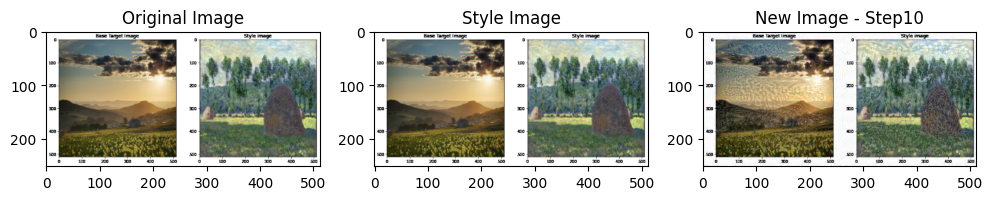